In [ ]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.5 MB/s eta 0:00:00
Mounted at /content/gdrive


## Deep Learning for Image Classification

This section provides a summary of the text on Deep Learning for Image Classification:

* **Beyond Basic Deep Learning:**
    * The focus shifts from a general introduction to delving deeper into the technical aspects.

* **Importance of Understanding Mechanics:**
    * While deep learning offers powerful tools, understanding the underlying mechanisms is crucial for optimal performance and troubleshooting.


* **Learning Approach:**
    * Introduce concepts progressively through practical problem-solving using real-world projects.

### **Challenge Progression:**
  * Lets move from basic dog vs. cat classification (considered too easy now) to a more intricate task: pet breed identification within the same dataset.

* **Realistic Workflow:**
    * Acknowledge the real-world process of working with new datasets, including data exploration, understanding data structure, and data extraction before model building.

In [ ]:
# We already downloaded the Pet dataset, and we can get a path to this dataset using the same code as in ch1.introduction:

from fastai.vision.all import *
path = untar_data(URLs.PETS)

#### Data Layouts for Deep Learning

This section discusses two common data layouts encountered in deep learning:

**1. Individual Files:**

* Represent individual data items like images or text documents.
* May be organized in folders for better structure.
* Filenames might encode information about the data item.

**2. Data Tables (e.g., CSV format):**

* Each row represents a data item.
* Can include filenames linking data to other formats (images, text).

**General Note:**

* Exceptions exist, especially in specific domains like genomics (binary databases, network streams).
* The vast majority of datasets use a combination of these two formats.


In [ ]:
# for colab
import os
os.mkdir("images")

In [ ]:
# To see what is in our dataset we can use the ls method:

Path.BASE_PATH = path
path.ls()

(#2) [Path('images'),Path('annotations')]

Data Exploration for Pet Image Classification

* **Dataset Structure:**
    * Contains separate directories for images and annotations.
* **Annotations Directory:**
    * Contains information about pet locations (not relevant for current classification task).  
* **Focus of this Chapter:**
    * Pet image classification (identifying pet types, not location).
* **Next Step:**
    * Exploring the `images` directory.


In [ ]:
(path/"images").ls()

(#7393) [Path('images/Maine_Coon_134.jpg'),Path('images/american_bulldog_76.jpg'),Path('images/yorkshire_terrier_27.jpg'),Path('images/Maine_Coon_72.jpg'),Path('images/Siamese_46.jpg'),Path('images/miniature_pinscher_52.jpg'),Path('images/Egyptian_Mau_201.jpg'),Path('images/yorkshire_terrier_82.jpg'),Path('images/scottish_terrier_105.jpg'),Path('images/boxer_159.jpg')...]

##### Fastai's `L` Class

This section describes `L`, a class commonly used by functions and methods returning collections in fastai.

* **Enhanced List:** `L` can be thought of as an improved version of the built-in Python `list` type, offering additional functionalities for common operations.
* **Output :** When displaying an `L` object in a Jupyter notebook, it shows:
    * `(#7393)`:
      * The number of items prefixed with "#" (e.g., "#7000").
    * `[Path('images/Maine_Coon_134.jpg'),Path('image...]`
      * An ellipsis (...) indicating only the first few items are shown (preventing overwhelming output).

* **Filename Structure:** Based on the provided filenames, we can see a pattern:
    * Pet breed name.
    * Underscore (_).
    * Number.
    * File extension.
    * eg: *basset_hound_112.jp*

* **Extracting Breed:** The goal is to create code to extract the breed name from a single path object.
* **Gradual Development:** Jupyter notebooks allow us to build and test the code progressively before applying it to the entire dataset.
* **Multiple Word Breeds:** We need to handle filenames with breeds containing multiple words (separated by spaces), not just relying on splitting at the first underscore. (*images/shiba_inu_122.jpg*)
* **Testing Code:** To test our code, we will select a specific filename for initial development.


In [ ]:
fname = (path/"images").ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Maine_Coon']

#### Extracting Pet Breed from Filenames with Regular Expressions

**Regular Expressions (Regex)**

* Powerful and flexible tool to extract information from strings.
* Defines a pattern to match specific parts of a string.
* Useful for extracting data like pet breed from filenames.


**Regular Expressions: Interesting Fact**

* Regular expressions come from the theory of "regular languages" in linguistics.
* Developed by Noam Chomsky for classifying grammar structures.

**Extracting Breed using Regular Expressions**

Starting Point:

* Use `findall` method to test against example filenames.

Example Regex:

```
re.findall(r'(.+)_\d+.jpg$', fname.name)
```

Explanation:

* Matches everything (`.+`) before the last underscore (`_`).
* Ensures the characters before the underscore are digits (`\d+`).
* Matches the ".jpg" extension.

Output:

* Extracts the pet breed (e.g., "great_pyrenees").


Now that we confirmed the regular expression works for the example, let's use it to label the whole dataset. fastai comes with many classes to help with labeling. For labeling with regular expressions, we can use the RegexLabeller class.

In this example we use the data block API we saw in *ch2.production* (in fact, we nearly always use the data block API—it's so much more flexible than the simple factory methods we saw in *ch1.introduction.ipynb*:

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

```python
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75))
```

These lines implement a fastai data augmentation strategy which we call presizing.
**Presizing** is a particular way to do image augmentation that is designed to minimize data destruction while maintaining good performance.


### Presizing Images for Deep Learning

**Importance of Presizing**

* Images need consistent dimensions for processing in tensors on GPUs.
* Minimize redundant computations during augmentation.
* Improve GPU efficiency by processing images in uniform sizes.

**Challenges of Augmentation after Resizing**

* Common augmentations (rotation, zoom) can introduce empty areas or degrade data quality.
* Interpolation for missing pixels reduces data quality.

**Presizing Strategies**
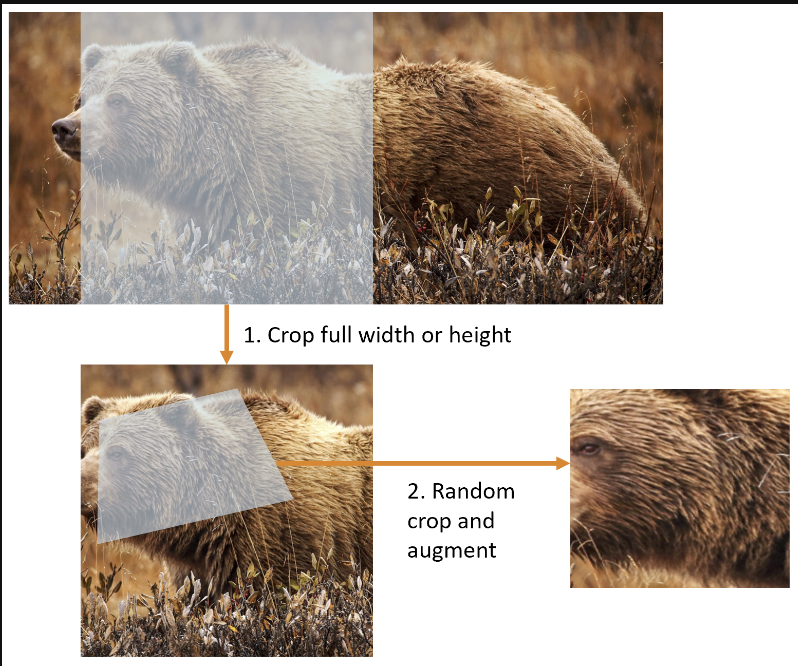

1. Resize to Large Dimensions:
    * Creates a buffer for further augmentation without empty zones.
    * Resize to a square with a large crop size.
    * Randomly crop the entire width or height on the training set.

2. GPU-based Augmentation:
    * Combine all augmentations (including final resize) into one operation.
    * Perform the combined operation on the GPU once for efficiency.
    * Single interpolation at the end for better quality.

**Presizing on Training vs. Validation Set**

* Training Set:
    * **Crop full width or height:** (`item_tfms`) Ensures consistent size, random area selection.
    * **Random crop and augment:** (`batch_tfms`) Efficient GPU processing with random cropping and augmentations.

* Validation Set:
    * Only resize to the final model size in batch transforms.
    * Center square crop used for validation.

**Implementing Presizing in fast.ai**

* Use `Resize` as an item transform with a large size.
* Use `RandomResizedCrop` as a batch transform with a smaller size.
    * Automatically included if `min_scale` is provided in `aug_transforms`.
* Alternatively, use `pad` or `squish` instead of cropping for initial resize.


The image below, shows the difference between an image that has been zoomed, interpolated, rotated, and then interpolated again (which is the approach used by all other deep learning libraries), shown here on the right, and an image that has been zoomed and rotated as one operation and then interpolated just once on the left (the fastai approach), shown here on the left.

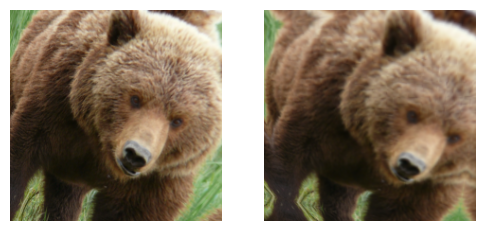

In [22]:
#id interpolations
#caption A comparison of fastai's data augmentation strategy (left) and the traditional approach (right).
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
# Place an image in the 'images/grizzly.jpg' subfolder where this notebook is located before running this
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

- **Presizing in Practice:**
  - Presizing significantly improves model accuracy.
  - Helps mitigate artifacts like reflection padding and loss of details in images.
  - Can lead to speedups in model training.

- **Data Validation with fastai:**
  - fastai library offers straightforward methods for inspecting data pre-training.
  - Ensures data integrity and suitability for model training.
  - Crucial step in the machine learning pipeline.

#### Checking and Debugging a DataBlock

**Importance of DataBlock Verification:**

* DataBlocks act as blueprints for data preparation.
* Similar to code with syntax errors, DataBlocks might not produce the intended outcome even if they run without errors.

**Verification before Training:**

* It's crucial to check the DataBlock's functionality before training a model.

**Verification Method:**

* Use the `show_batch` method to preview the data batches generated by the DataBlock.


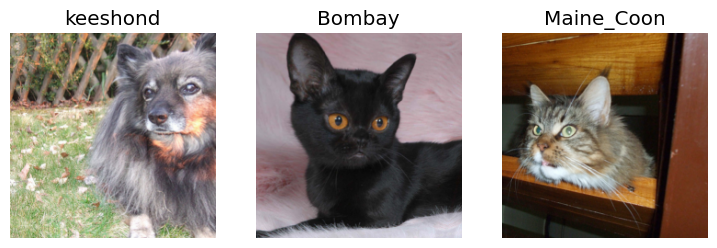

In [23]:
dls.show_batch(nrows=1, ncols=3)

#### Data Validation in Pet Breed Classification

**Checking Image Labels:**

* Manually verify if each image appears to have the correct label for its breed.
* Acknowledge potential limitations in domain expertise (e.g., not knowing all pet breeds).
* Utilize Google Images to search for unfamiliar breeds and compare with dataset images.

**Debugging with `DataBlock.summary()`:**

* Importance: Helps identify potential errors introduced during DataBlock creation.
* Functionality:
    * Attempts to create a batch from the data source.
    * Provides detailed information about the created batch.
    * Pinpoints the exact location of errors during batch creation.
    * Offers guidance on resolving common mistakes (e.g., missing `Resize` transform).


In [24]:
# Here is what the summary would look like in that case (note that the exact text may have changed since the time of writing, but it will give you an idea):
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")


Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/saint_bernard_121.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/saint_bernard_121.jpg
    applying partial gives
      saint_bernard
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(30)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(30))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up

RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `TensorImage`:
	Item at index 0 has shape: torch.Size([3, 500, 375])
	Item at index 2 has shape: torch.Size([3, 375, 500])

Please include a transform in `after_item` that ensures all data of type TensorImage is the same size

**Data Preparation and Initial Training for Image Classification**

Data Processing Workflow

* **Data Acquisition and Splitting:** Understanding how the data was gathered and divided into training, validation, etc. sets.
* **Sample Creation:** Following the process of transforming filenames into usable samples (image, category tuples).
* **Item Transformation:** Examining the item transformations applied to the data.
* **Batch Collation Challenges:** Identifying potential issues arising from different sample shapes during batch creation.

**Importance of Early Model Training**

* Benefits of Early Training:
    * Establishing a baseline performance metric.
    * Detecting potential problems (data quality, model incapability).

* **Recommendation:** Training a simple model as the next step after data preparation.

In [25]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.481150,0.329414,0.109608,00:17


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,0.511071,0.324879,0.094046,00:19
1,0.327150,0.240995,0.081191,00:19


#### Understanding Model Training:

- **Epochs and Results:**
  - Table displays results after each training epoch.
  - An epoch constitutes a complete pass through all data images.
  - Columns include average loss on training set, loss on validation set, and requested metrics (e.g., error rate).

- **Loss Function:**
  - Loss function optimizes model parameters.
  - fastai autonomously selects an appropriate loss function.
  - Selection based on data type and model; defaults to cross-entropy loss for image data with categorical outcomes.

### Cross-Entropy Loss

This section introduces Cross-Entropy Loss as a loss function for multi-class classification problems.

* **Benefits of Cross-Entropy Loss:**
    * Applicable to dependent variables with more than two categories (unlike the previous chapter's loss function).
    * Enables faster and more reliable training.

* **Understanding Cross-Entropy Loss:**
    * Requires understanding the data and activation outputs used by the loss function (explained in following sections).


#### Viewing Activations and Labels
Let's take a look at the activations of our model. To actually get a batch of real data from our DataLoaders, we can use the one_batch method:

In [26]:
x,y = dls.one_batch()
"""
As you see, this returns the dependent and independent variables, as a mini-batch.
Let's see what is actually contained in our dependent variable:
"""
y


TensorCategory([17, 29,  0, 24,  2, 29, 15,  1, 35, 21,  4,  6, 31, 28, 36, 28,  2,  5,  3, 17, 24, 24, 25,  8,  7, 32, 13, 22, 14,  4, 33,  3, 28, 16,  9,  5, 13, 17, 22, 10, 29,  3, 31,  2, 13, 26,
                12, 12, 15, 33,  4, 25,  9,  3, 31, 11, 31, 27, 27,  7,  6, 25,  4,  6], device='cuda:0')

- Batch size: 64 rows in the tensor.
- Each row represents a single integer between 0 and 36, denoting 37 possible pet breeds.
- Predictions (activations of the final layer) can be viewed using `Learner.get_preds`.
- `get_preds` takes a dataset index (0 for train, 1 for valid) or an iterator of batches.
- By passing a list with the batch, predictions can be obtained.
- It returns predictions and targets by default.
- If targets are already available, they can be ignored by assigning to the special variable `_`.

In [27]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([2.3924e-05, 1.6498e-06, 3.4028e-08, 4.9775e-06, 4.7962e-08, 2.2013e-07, 4.1603e-09, 1.3525e-08, 8.2323e-08, 2.1787e-06, 2.5312e-06, 1.0407e-05, 2.0682e-08, 6.6652e-05, 1.0173e-06, 6.0583e-06,
        1.4555e-05, 9.9665e-01, 3.0153e-06, 4.4640e-07, 9.0590e-07, 6.4925e-08, 7.5739e-08, 6.7969e-07, 1.1060e-06, 2.2280e-07, 3.1755e-03, 6.2940e-08, 2.8918e-05, 1.0292e-07, 2.7191e-08, 2.5720e-07,
        1.6233e-06, 1.2097e-06, 3.2267e-06, 4.6227e-07, 8.2422e-07])

In [28]:
# The actual predictions are 37 probabilities between 0 and 1, which add up to 1 in total:
len(preds[0]),preds[0].sum()

(37, tensor(1.0000))

#### Softmax Activation Function in Classification Models

* **Purpose:** Transforms model activations into class probabilities for prediction.

* **Properties:**
    * Ensures activations are between 0 and 1.
    * Guarantees activations sum to 1.

* **Similarity to Sigmoid:** Shares the function of limiting output between 0 and 1, but is used in multi-class classification scenarios.

* **Example with Sigmoid:** Applies sigmoid to a single activation column, resulting in probabilities between 0 and 1 (useful for binary classification).

* **Multi-Class Classification:**
    * Requires more than one activation per image (one for each category).
    * Example: A model predicting 3s and 7s would have two activations - one for each class.


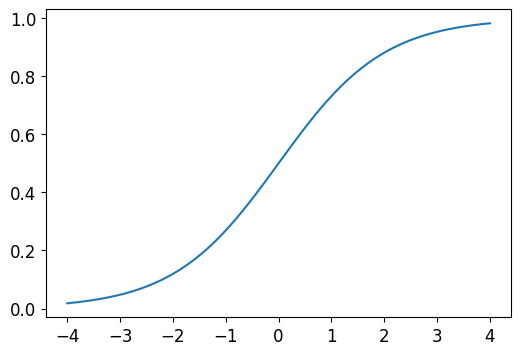

In [29]:
plot_function(torch.sigmoid, min=-4,max=4)

In [30]:
# assuming we have 6 images and 2 possible categories (where the first column represents 3s and the second is 7s):

torch.random.manual_seed(42)
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [31]:
# We can't just take the sigmoid of this directly, since we don't get rows that add to 1 (i.e., we want the probability of being a 3 plus the probability of being a 7 to add up to 1):
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

- **Neural Net for Binary Classification:**
  - In previous work, a single activation per image was generated by our neural net, passed through the sigmoid function, representing the model's confidence in the input being a 3.
  - Binary problems, like this, treat the target as a single boolean value.
  - The neural net returns one activation per category, as seen in the bear classifier.
- **Interpreting Activations in Binary Classification:**
  - In the binary case, activations indicate relative confidence between categories (e.g., 3 versus 7).
  - The absolute values of activations don't matter; only their relative magnitudes are significant.
- **Sigmoid Function in Binary Classification:**
  - Direct application of sigmoid on two activations is possible.
  - By computing the difference between activations (reflecting confidence gap between categories) and applying sigmoid, we determine the confidence in one category over the other.

In [32]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

- The softmax function is used to convert raw scores or logits into probabilities.
- For a single column input, softmax behaves like the sigmoid function.
- It ensures that the probabilities sum up to 1 across all classes.
- In Python, the softmax function can be implemented as:
  ```python
  def softmax(x):
      return exp(x) / exp(x).sum(dim=1, keepdim=True)
  ```
- The exponential function (exp) is defined as \( e^x \), where \( e \) is Euler's number, approximately 2.718.
- Exp increases rapidly and always yields positive values.
- The softmax function normalizes the input values by exponentiating each value and dividing by the sum of exponentiated values across the specified dimension.
- This normalization process ensures that the output values represent probabilities.
- Softmax can handle multiple columns by applying the same normalization technique across each row.

In [33]:
#Let's check that softmax returns the same values as sigmoid for the first column, and those values subtracted from 1 for the second column:

sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

#### Softmax Function in Multi-Class Classification

**Softmax Explained**

* Softmax is the go-to function for multi-category classification (more than 2 categories).

* It ensures probabilities of each category:
    * Add up to 1 (using sum normalization).
    * Are between 0 and 1 (achieved through exponentiation).
* Softmax amplifies the larger activation values, making them closer to 1 in the probability distribution.
* This function is suitable when each image has a definitive label (during training).
  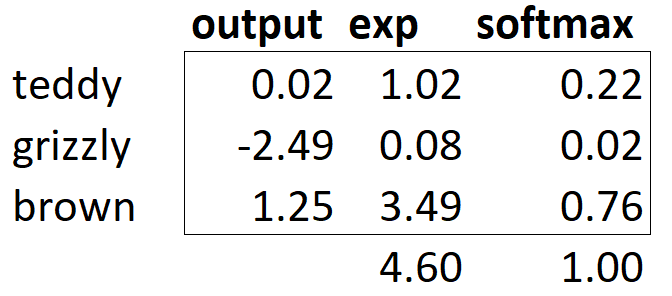

#### Softmax vs. Sigmoid

* Sigmoid is limited to binary classification (2 categories).
* Softmax generalizes sigmoid for multi-class problems.

#### Log Likelihood and Cross-Entropy Loss

* Softmax is used in conjunction with cross-entropy loss (covered later).
* Cross-entropy loss is an extension of the binary classification loss function used earlier.
* It can handle multi-category classification and even multi-label classification (discussed in next Chapters).


In [34]:
# Let's try to implement this in PyTorch. For our synthetic 3s and 7s example, let's say these are our labels:
targ = tensor([0,1,0,1,1,0])

# and these are the softmax activations:
print("softmax activations: ",sm_acts)

softmax activations:  tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])


In [35]:
#Then for each item of targ we can use that to select the appropriate column of sm_acts using tensor indexing, like so:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [50]:
# To see exactly what's happening here, let's put all the columns together in a table.
# Here, the first two columns are our activations, then we have the targets and the row index. We explain the last column, result below:


#hide_input
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['result'] = sm_acts[range(6), targ]
t = df.style.hide()
t

3,7,targ,idx,result
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


- The result column calculation in a table involves using the targ and idx columns as indices into a two-column matrix containing the 3 and 7 columns.
- This operation is represented by `sm_acts[idx, targ]`.
- It's noted that this method works effectively with more than two columns as well.
- Consideration is given to adding an activation column for each digit (0 through 9), where targ contains a number from 0 to 9.
- PyTorch offers a function that mirrors the functionality of sm_acts[range(n), targ] but negates the values, named nll_loss (NLL stands for negative log likelihood).

In [42]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [43]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

**PyTorch: Understanding nll_loss Function**

- **Function Misconception:**
  - Despite its name, `nll_loss` does not take the log directly.
  - The "nll" stands for "negative log likelihood," but it assumes the log has already been taken.

- **Logarithm Usage:**
  - The reason for using logarithms is to prevent numerical underflow when dealing with probabilities.
  - Multiplying numerous negative numbers together (as in cross entropy loss) can lead to computational issues.

- **Logarithmic Transformation:**
  - To address this, probabilities are transformed using logarithms.
  - PyTorch provides `log_softmax` function for this transformation, combining log and softmax efficiently.
  - `nll_loss` is intended to be used after applying `log_softmax`.

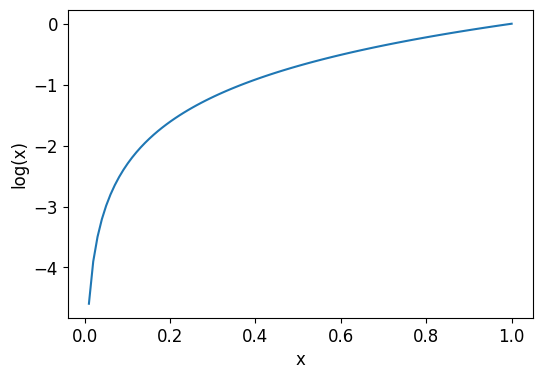

In [44]:
# There is a mathematical function that does exactly this: the logarithm (available as torch.log). It is not defined for numbers less than 0, and looks like this between 0 and 1:


plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

#### Logarithms and Loss Function in Deep Learning

**Why Use Logarithms?**

* Enhances model's ability to distinguish between small probabilities (e.g., 0.01 vs 0.001).
* Prevents small but significant differences from being overlooked.

**Logarithm Basics:**

* Logarithm function relates exponential terms: `y = b^a` and `a = log(y, b)`.
* Python's `log` function uses base `e` (approximately 2.718...).

**Logarithm's Key Property:**

* `log(a * b) = log(a) + log(b)`
* Logarithms increase linearly when the underlying signal increases exponentially.

**Applications of Logarithms:**

* Richter scale (earthquake severity)
* dB scale (noise levels)
* Financial charts (visualizing compound growth rates)
* Computer science (easier handling of very large/small numbers through addition instead of multiplication)

**Logarithms and Loss Function:**

* Logarithm of a number approaches negative infinity as the number approaches zero.
* In loss functions (evaluating model performance), we want:
    * Smaller loss for good predictions (closer to probability 1).
    * Larger loss for bad predictions (closer to probability 0).
    * Logarithms achieve this by amplifying the penalty for lower probabilities.

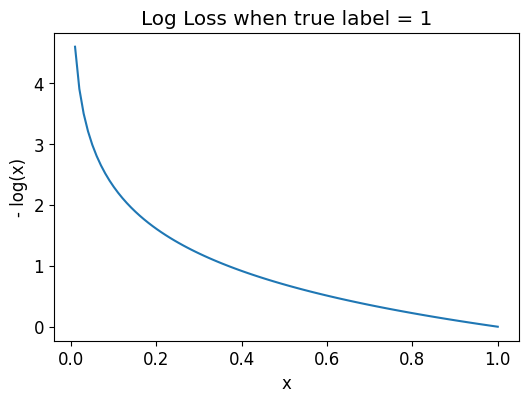

In [45]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='- log(x)', title = 'Log Loss when true label = 1')


In [51]:
# Let's go ahead and update our previous table with an additional column, loss to reflect this loss function:

from IPython.display import HTML
df['loss'] = -torch.log(tensor(df['result']))
t = df.style.hide()
t

3,7,targ,idx,result,loss
0.602469,0.397531,0,0,0.602469,0.506720
0.502065,0.497935,1,1,0.497935,0.697285
0.133188,0.866811,0,2,0.133188,2.015990
0.996640,0.003360,1,3,0.003360,5.695763
0.595949,0.404051,1,4,0.404051,0.906213
0.366118,0.633882,0,5,0.366118,1.004798


**Understanding Cross-Entropy Loss in Classification**

**Impact of Confident Wrong Predictions:**

* High loss for predictions with high confidence on the wrong class.
* Logarithmic loss function penalizes these confident-but-incorrect predictions more heavily.

**Calculating Loss:**

* Loss is calculated based on the correct label column.
* Other columns (due to softmax properties) contribute indirectly by affecting the activation for the correct label.


#### Negative Log Likelihood (Cross-Entropy Loss):

* Taking the mean of negative log probabilities gives the negative log likelihood loss.
* PyTorch's `nll_loss` assumes pre-logged softmax outputs.

**Cross-Entropy Loss:**

* Combination of softmax and negative log-likelihood.
* Implemented as `nn.CrossEntropyLoss` in PyTorch (performs log_softmax and then nll_loss).

In [52]:
#In PyTorch, this is available as nn.CrossEntropyLoss (which, in practice, actually does log_softmax and then nll_loss)
loss_func = nn.CrossEntropyLoss()

# As you see, this is a class. Instantiating it gives you an object which behaves like a function:
loss_func(acts, targ)

tensor(1.8045)

In [53]:
# All PyTorch loss functions are provided in two forms, the class just shown above, and also a plain functional form, available in the F namespace:
F.cross_entropy(acts, targ)

tensor(1.8045)

Either one works fine and can be used in any situation. We've noticed that most people tend to use the class version, and that's more often used in PyTorch's official docs and examples, so we'll tend to use that too.

In [54]:
# By default PyTorch loss functions take the mean of the loss of all items. You can use reduction='none' to disable that:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

- Cross-Entropy Loss:
  - Gradient of `cross_entropy(a, b) = softmax(a) - b`.
  - Gradient is proportional to the difference between prediction and target.
  - Similar to mean squared error in regression.
  - Linear gradient prevents sudden jumps or exponential increases, leading to smoother model training.

- Interpreting Model Predictions:
  - Loss function evaluates model performance but doesn't indicate if it's good.
  - Need methods to interpret model predictions effectively.

### Model Interpretation in Machine Learning

* **Challenges of Loss Functions:**
    * Designed for computer optimization, not human interpretation.

* **Metrics for Human Understanding:**
    * Separate from optimization process.
    * Provide insights into model performance for humans.

* **Example Scenario:**
    * High accuracy metric suggests good performance, but further investigation is needed to identify areas for improvement.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


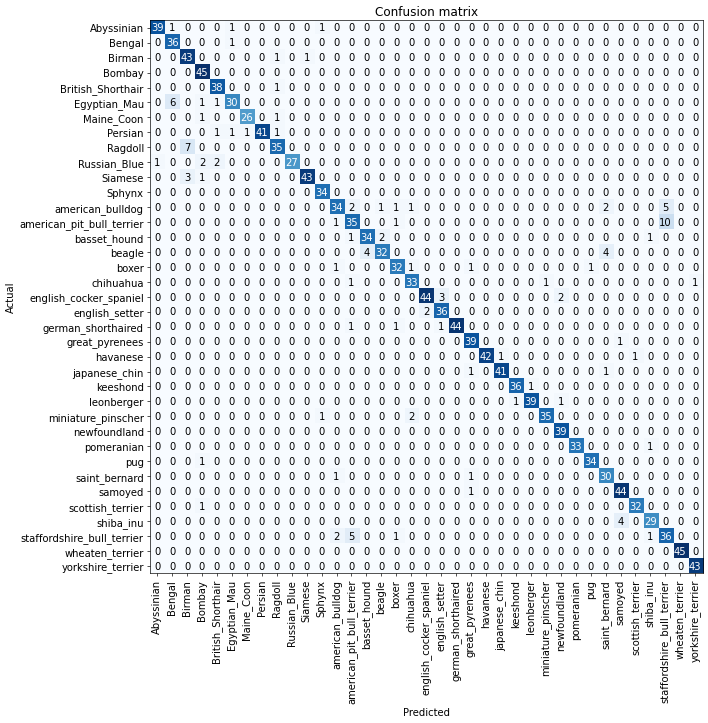

In [55]:
# We saw in <<chapter_intro>> that we can use a confusion matrix to see where our model is doing well, and where it's doing badly:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Oh dear—in this case, a confusion matrix is very hard to read. We have 37 different breeds of pet, which means we have 37×37 entries in this giant matrix! Instead, we can use the most_confused method, which just shows us the cells of the confusion matrix with the most incorrect predictions (here, with at least 5 or more):

In [56]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 10),
 ('Ragdoll', 'Birman', 7),
 ('Egyptian_Mau', 'Bengal', 6),
 ('american_bulldog', 'staffordshire_bull_terrier', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5)]

### Evaluating Image Recognition Model for Pet Breeds

* **Challenge of Evaluating Model Accuracy:** Difficulty in distinguishing between model errors and actual breed variations in real-world data.

* **Leveraging Expert Opinions:** Consulting online resources (like Google) to compare model errors with known breed complexities.

* **Comforting Result:** Discovering common errors align with existing controversies among breeders, suggesting the model is performing well despite the initial concern.


### Improving Deep Learning Model Training

#### Techniques for Better Training

This section explores methods to enhance deep learning model training.

* **Transfer Learning and Fine-Tuning:**
    * Explanation of transfer learning and its role in model improvement will be provided.
    * Techniques for effective fine-tuning of pre-trained models to avoid disrupting pre-trained weights will be covered.

#### Learning Rate Optimization

* **Importance of Learning Rate:**
    * Selecting an appropriate learning rate is crucial for efficient training.
    * A learning rate that's too low can lead to:
        * Extended training times (many epochs)
        * Increased risk of overfitting (memorizing training data)

* **Learning Rate Finder:**
    * Fastai offers a tool to help determine the optimal learning rate.


In [57]:
# So let's just make our learning rate really high, right? Sure, let's try that and see what happens:


learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)


epoch,train_loss,valid_loss,error_rate,time
0,2.655838,4.175005,0.443166,00:17


epoch,train_loss,valid_loss,error_rate,time
0,3.211960,1.636554,0.470907,00:19


- **Issue with Optimizer:**
  - Overshooting the minimum loss, leading to divergence rather than convergence.
  - Repeating this process exacerbates the issue, driving the model further away from optimization.

- **Leslie Smith's Learning Rate Finder (2015):**
  - Start with an extremely small learning rate, ensuring it's manageable.
  - Apply this rate for one mini-batch, observe subsequent losses.
  - Gradually increase the learning rate by a percentage (e.g., doubling it) for each mini-batch.
  - Monitor loss after each adjustment, doubling the learning rate until loss worsens instead of improving, indicating overshooting.
  - Select a learning rate slightly lower than this point of divergence.

- **Recommended Learning Rate Selection:**
  - Choose either:
    - One order of magnitude less than where the minimum loss was achieved (minimum divided by 10).
    - The last point where the loss was clearly decreasing.

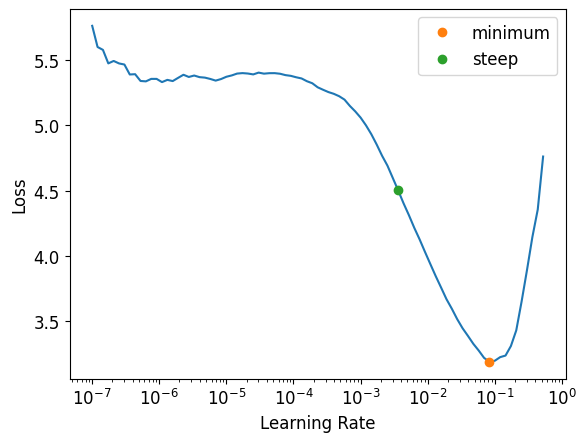

In [58]:
# The learning rate finder computes those points on the curve to help you.
# Both these rules usually give around the same value.
# In the first chapter, we didn't specify a learning rate, using the default value from the fastai library (which is 1e-3):
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [59]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-03, steepest point: 3.63e-03


- **Learning Rate Analysis:**
  - Plot observation:
    - In the range 1e-6 to 1e-3, no significant change occurs, and the model doesn't train effectively.
    - Subsequently, loss decreases until reaching a minimum.
    - After the minimum, loss starts increasing again.
  - Optimal learning rate range:
    - Avoid learning rates greater than 1e-1 to prevent divergence during training.
    - 1e-1 is already too high, leading to leaving the period of steady loss decrease.

In [60]:
# In this learning rate plot it appears that a learning rate around 3e-3 would be appropriate, so let's choose that:


learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.288585,0.336604,0.106901,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.587925,0.439385,0.123816,00:19
1,0.328805,0.250448,0.073072,00:19




**Finding a good learning rate:**
* Crucial for optimal performance in training neural networks (since 1950s).
* Breakthrough work by Leslie Smith in 2015 (not requiring advanced resources).
* Requires common sense, creativity, and tenacity.

**Learning Rate Finder Plot:**

* Uses logarithmic scale (focuses on order of magnitude).

**Key Point:** Advancements in deep learning can come from simple ideas, not just vast resources or complex mathematics.


#### Transfer Learning with Freezing and Fine-tuning in Fast.ai

**Key Points:**

* **Transfer Learning Recap:** Pre-trained models (e.g., ImageNet) are fine-tuned for new tasks.

* **Convolutional Neural Networks (CNNs):**
    * Consist of many linear layers with non-linear activations.
    * Final layers have an output size matching the number of classes (e.g., softmax for classification).

* **Transfer Learning and the Final Layer:**
    * The final layer from the pre-trained model is specific to the original task and gets removed.
    * A new final layer with the desired number of outputs for the new task is added (e.g., 37 for pet breeds).

* **Pre-trained Model Knowledge:**
    * The *new final layer* starts with random weights.
    * As we saw in the images from the [Zeiler and Fergus paper](https://arxiv.org/pdf/1311.2901.pdf) in
       * Layers before the final layer encode general image classification knowledge (e.g., edges, eyeballs, fur).
         * The first few layers encode very general concepts, such as finding gradients and edges,
         * Later layers encode concepts that are still very useful for us, such as finding eyeballs and fur.



* **Fine-tuning Goal:**
    * Leverage pre-trained knowledge for the new task (pet breeds).
    * Only adjust pre-trained weights as necessary for the specific task.

* **Freezing Layers during Fine-tuning:**
    * Update weights only in the newly added final layers (random weights).
    * Keep pre-trained weights unchanged (frozen).

* **Fast.ai and Freezing:**
    * Freezes all pre-trained layers by default during fine-tuning with `fine_tune`.

* **Fine-tuning with `fine_tune`:**
    1. Trains new final layers for 1 epoch (frozen pre-trained layers).
    2. Unfreezes all layers and trains for the specified number of epochs.

* **Custom Fine-tuning Approach:**
    * Use underlying methods directly for more control (e.g., `learn.fine_tune??`).

* **Manual Fine-tuning Example:**
    1. Train new final layers for 3 epochs using `fit_one_cycle` (explained later).


In [61]:
learn.fine_tune??

In [62]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.155275,0.360173,0.117050,00:17
1,0.541643,0.259491,0.079161,00:17
2,0.324320,0.240857,0.077808,00:17


SuggestedLRs(valley=6.30957365501672e-05)

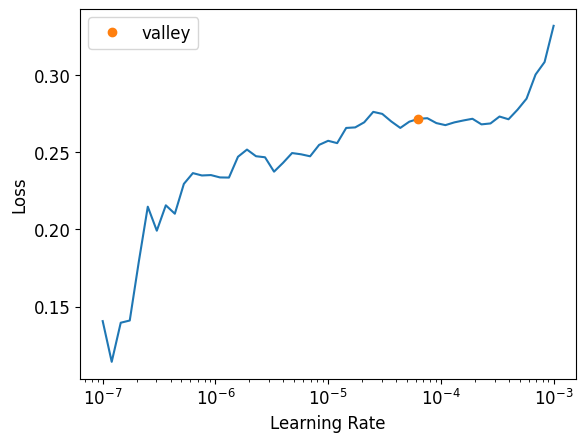

In [63]:
#Then we'll unfreeze the model:
learn.unfreeze()

# and run lr_find again, because having more layers to train, and weights that have already been trained for three epochs,
# means our previously found learning rate isn't appropriate any more:
learn.lr_find()

Note that the graph is a little different from when we had random weights: we don't have that sharp descent that indicates the model is training. That's because our model has been trained already. Here we have a somewhat flat area before a sharp increase, and we should take a point well before that sharp increase—for instance, 1e-5. The point with the maximum gradient isn't what we look for here and should be ignored

In [64]:
# Let's train at a suitable learning rate:
learn.fit_one_cycle(6, lr_max=1e-5)


epoch,train_loss,valid_loss,error_rate,time
0,0.238595,0.235483,0.076455,00:19
1,0.237129,0.219326,0.069689,00:19
2,0.216748,0.217666,0.062923,00:18
3,0.189263,0.214279,0.064953,00:19
4,0.194815,0.212520,0.064276,00:19
5,0.194186,0.211727,0.062923,00:19


This has improved our model a bit, but there's more we can do. The deepest layers of our pretrained model might not need as high a learning rate as the last ones, so we should probably use different learning rates for those—this is known as using *discriminative learning rates*.

#### Discriminative Learning Rates in Fine-Tuning

**Why Use Discriminative Learning Rates?**

* Protects Pre-trained Weights:
    * Even after unfreezing, pre-trained weights shouldn't have a high learning rate due to extensive training on large datasets.

* Layer-Specific Learning Needs:
    * Different layers learn varying complexities:
        * Early layers: Learn fundamental features (edges, gradients).
        * Later layers: Learn more specific features ("eye", "sunset").
    * This suggests fine-tuning later layers faster than earlier ones.
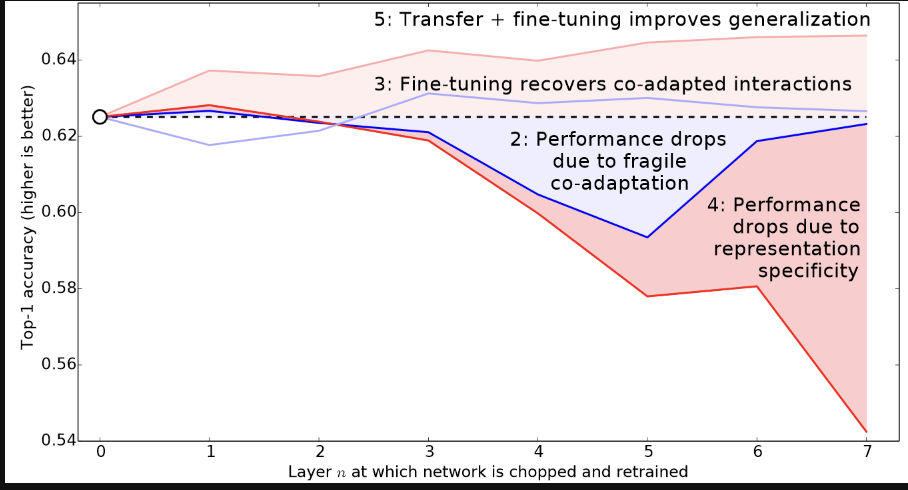

**Fastai's Approach:**

* Utilizes discriminative learning rates (inspired by ULMFiT for NLP).
* Simple strategy:
    * Lower learning rate for **early layers** of the neural network.
    * Higher learning rate for **later layers** (especially newly added layers).
* The first value passed will be the learning rate in the earliest layer of the neural network.
* The second value will be the learning rate in the final layer.
* The layers in between will have learning rates that are multiplicatively equidistant throughout that range.

**Justification:**

* Based on research by [Jason Yosinski (2014)](https://arxiv.org/abs/1411.1792):
    * Different layers in transfer learning should have different training speeds (reference provided).
    * 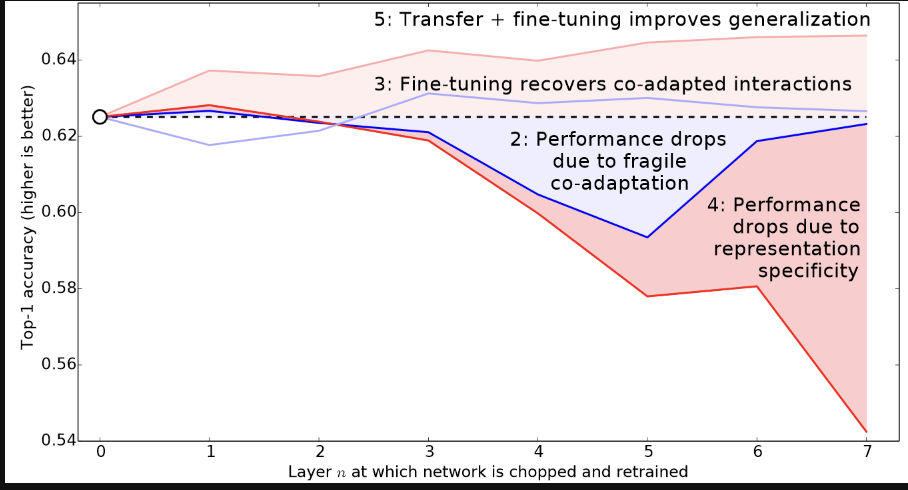


In [65]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.148909,0.350970,0.113667,00:17
1,0.528074,0.248814,0.081867,00:17
2,0.329035,0.229143,0.071719,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.241618,0.220304,0.073072,00:19
1,0.247290,0.215810,0.067659,00:19
2,0.226076,0.205669,0.066982,00:19
3,0.213637,0.196223,0.066982,00:19
4,0.183447,0.199282,0.064276,00:19
5,0.161006,0.193918,0.062246,00:19
6,0.155743,0.191875,0.064953,00:19
7,0.138525,0.183356,0.059540,00:19
8,0.126619,0.185092,0.056834,00:19
9,0.120062,0.186368,0.059540,00:18


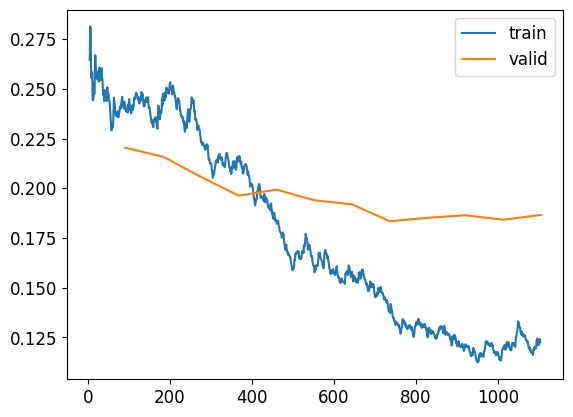

In [66]:
"""
Now the fine-tuning is working great!
fastai can show us a graph of the training and validation loss:
"""
learn.recorder.plot_loss()

- **Training Loss vs. Validation Loss:**
  - Training loss consistently improves over epochs.
  - Validation loss improvement slows, sometimes worsens, indicating overfitting.
  - **Overfitting**: Model becomes overconfident, may generalize poorly to unseen data.
  - Despite worsening validation loss, accuracy may still improve, emphasizing the importance of chosen metrics over loss function.
  - Loss function aids optimization, but accuracy/metrics are the ultimate goals.

- **Determining Training Duration:**
  - Decision: How long to train the model.
  - Next consideration in model training process.

#### Selecting the Number of Epochs in Deep Learning

This excerpt provides insights on choosing the optimal number of epochs for training a deep learning model.

**Key Points:**

* **Time Constraints:** Training time is often a limiting factor. Choose an initial epoch number based on your desired training duration.
* **Monitor Training Progress:** Analyze training and validation loss plots along with relevant metrics (accuracy, precision, etc.) to identify improvement trends.
* **Overfitting and Metrics:** Don't solely rely on validation loss; worsening metrics at later epochs indicate overfitting (model memorizing data instead of learning). Focus on practical metrics, not just the loss function.
* **Early Stopping (Traditional Approach):**
    * Saving models at each epoch and selecting the one with the best validation accuracy might not be optimal.
    * Early stopping often occurs before the learning rate reaches its most effective low values.
* **Overfitting Solution:**
    * If overfitting occurs, retrain the model from scratch.
    * Use the epoch range where your previous best results were achieved as a guide for the new training duration.
* **Prioritize Deeper Architectures:**
    * If training time allows, consider using a deeper network architecture (more parameters) instead of simply increasing epochs.

#### Deeper Architectures in Deep Learning

**Impact of Model Size:**

* More parameters (achieved through more layers) generally lead to better accuracy, but with limitations.

**Challenges of Increased Model Size:**

* **Overfitting:** Larger models are more prone to overfitting due to the increased number of parameters.
* **GPU Memory:** Training deeper models requires more GPU RAM, potentially leading to out-of-memory errors.
* **Training Time:** Training deeper models takes significantly longer.

**Solutions for Training Deeper Models:**

* **Reduced Batch Size:** Using smaller batches of images during training can address memory limitations.
* **Mixed-Precision Training:** This technique utilizes less precise numbers (fp16) for faster training while maintaining acceptable accuracy (supported by most recent NVIDIA GPUs).
* **Tensor Cores:** Certain NVIDIA GPUs have special hardware (tensor cores) that significantly accelerate deep learning training by *2-3x* (enabled using `to_fp16()` in fastai).


In [67]:
"""
You can't really know ahead of time what the best architecture for your particular problem is—you need to try training some.
So let's try a ResNet-50 now with mixed precision:
"""

from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.172517,0.460797,0.140054,00:18
1,0.821815,0.329309,0.110284,00:18
2,0.552137,0.318718,0.098782,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.271217,0.248146,0.079838,00:19
1,0.255710,0.239387,0.076455,00:19
2,0.197551,0.251503,0.073748,00:19
3,0.125822,0.230450,0.060893,00:19
4,0.084432,0.231455,0.066982,00:19
5,0.065336,0.220274,0.061570,00:19


You'll see here we've gone back to using fine_tune, since it's so handy! We can pass freeze_epochs to tell fastai how many epochs to train for while frozen. It will automatically change learning rates appropriately for most datasets.

In this case, we're not seeing a clear win from the deeper model. This is useful to remember—bigger models aren't necessarily better models for your particular case! Make sure you try small models before you start scaling up.

## Image Modeling Techniques for Improved Accuracy (Summary)

**Building Better Image Models**

* This chapter covers practical tips to improve image model accuracy and training speed.
  * Data Preprocessing Techniques:
      * Image resizing
      * Data block summarization
  * Model Fitting Techniques:
      * Learning rate finder
      * Unfreezing layers for fine-tuning
      * Discriminative learning rates for different layers
      * Setting optimal number of epochs
      * Utilizing deeper architectures

**Understanding Cross-Entropy Loss**

* This section emphasizes the importance of understanding cross-entropy loss, a fundamental concept in image classification models.
  * It's not crucial to implement the function from scratch, but grasping its inputs and outputs is essential.
  * Cross-entropy loss is used in almost every classification model (or a variant of it).
  * Debugging models, deploying models to production, and improving accuracy all rely on understanding loss function behavior.

**Learning Tips for Cross-Entropy Loss**

* If the concept isn't clear, revisit the previous chapter on `mnist_loss` for a solid foundation.
* Work through the provided code notebooks step-by-step to understand each component of cross-entropy loss.
* Experiment by creating small tensors and feeding them into the loss function to observe the outputs.
* Explore alternative loss functions (understanding that cross-entropy loss with SGD often leads to faster training and better accuracy).
